In [1]:
import wrds
import pandas as pd
import numpy as np
import ot
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import scipy as sp

In [3]:
conn = wrds.Connection()

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [2]:
sp500_tickers = []
with open('sp500.txt', 'r') as f:
    for line in f:
        sp500_tickers.append(line.strip())
sp500_tickers[:5]

['AAPL', 'NVDA', 'MSFT', 'AMZN', 'GOOGL']

In [6]:
ibes_tickers = []
for t in tqdm(sp500_tickers):
    try:
        data = conn.raw_sql(f"""SELECT ticker, oftic, cname, estimator, analys, FPI, MEASURE, VALUE, FPEDATS, ANNDATS, ANNTIMS, ACTUAL, ANNDATS_ACT, ANNTIMS_ACT
                         FROM tr_ibes.det_epsus
                         WHERE oftic = '{t}'
                         and anndats >= '01/01/2024'
                         and fpi = '6'
                         """)
        if data.shape[0] == 0:
            print(f"No data for {t}")
        else:
            ibes_ticker = data['ticker'].iloc[0]
            ibes_tickers.append((t, ibes_ticker))
        # print(t, data.shape)
    except Exception as e:
        print(f"Error for {t}: {e}")

 76%|███████▌  | 381/501 [00:18<00:05, 22.90it/s]

No data for VRSN


 78%|███████▊  | 393/501 [00:19<00:04, 22.09it/s]

No data for L


 83%|████████▎ | 414/501 [00:19<00:03, 24.16it/s]

No data for NWS


100%|██████████| 501/501 [00:23<00:00, 21.23it/s]

No data for AMTM


In [17]:
for oftic, ibes in tqdm(ibes_tickers):
    data = conn.raw_sql(f"""SELECT ticker, oftic, cname, estimator, analys, FPI, MEASURE, VALUE, FPEDATS, ANNDATS, ANNTIMS, ACTUAL, ANNDATS_ACT, ANNTIMS_ACT
                         FROM tr_ibes.det_epsus
                         WHERE ticker = '{ibes}'
                         and anndats >= '01/01/2020'
                         and fpi = '6'
                         """)
    data.to_csv(f"data/ibes/{oftic}.csv", index=False)

100%|██████████| 497/497 [00:29<00:00, 16.78it/s]


In [ ]:
with open('ibes_tickers.pkl', 'wb') as f:
    pickle.dump(ibes_tickers, f)

In [3]:
with open('ibes_tickers.pkl', 'rb') as f:
    ibes_tickers = pickle.load(f)
    
ibes_data = dict()
for oftic, ibes in tqdm(ibes_tickers):
    data = pd.read_csv(f"data/ibes/{oftic}.csv")
    ibes_data[oftic] = data

100%|██████████| 497/497 [00:00<00:00, 932.84it/s]


In [4]:
ibes_data['AAPL'].head()

,ticker,oftic,cname,estimator,analys,fpi,measure,value,fpedats,anndats,anntims,actual,anndats_act,anntims_act
0,AAPL,AAPL,APPLE,1267.0,193808.0,6,EPS,1.1500,2019-12-31,2020-01-03,00:49:00,1.2475,2020-01-28,16:30:00
1,AAPL,AAPL,APPLE,3374.0,110208.0,6,EPS,1.1775,2019-12-31,2020-01-05,12:10:00,1.2475,2020-01-28,16:30:00
2,AAPL,AAPL,APPLE,930.0,191412.0,6,EPS,1.1775,2019-12-31,2020-01-09,07:00:00,1.2475,2020-01-28,16:30:00
3,AAPL,AAPL,APPLE,2301.0,83036.0,6,EPS,1.1450,2019-12-31,2020-01-09,13:00:00,1.2475,2020-01-28,16:30:00
4,AAPL,AAPL,APPLE,79.0,108299.0,6,EPS,1.1175,2019-12-31,2020-01-13,06:34:00,1.2475,2020-01-28,16:30:00


In [5]:
ibes_data['AAPL']['anndats_act'].dropna().unique()

array(['2020-01-28', '2020-04-30', '2020-07-30', '2020-10-29',
       '2021-01-27', '2021-04-28', '2021-07-27', '2021-10-28',
       '2022-01-27', '2022-04-28', '2022-07-28', '2022-10-27',
       '2023-02-02', '2023-05-04', '2023-08-03', '2023-11-02',
       '2024-02-01', '2024-05-02', '2024-08-01', '2024-10-31'],
      dtype=object)

In [10]:
ibes_data['NVDA']['anndats_act'].dropna().unique()

array(['2020-02-13', '2020-05-21', '2020-08-19', '2020-11-18',
       '2021-02-24', '2021-05-26', '2021-08-18', '2021-11-17',
       '2022-02-16', '2022-05-25', '2022-08-24', '2022-11-16',
       '2023-02-22', '2023-05-24', '2023-08-23', '2023-11-21',
       '2024-02-21', '2024-05-22', '2024-08-28'], dtype=object)

In [161]:
for t, data in ibes_data.items():
    data = data.dropna()
    if data['anndats_act'].unique().shape[0] != 20:
        print(t, data['anndats_act'].unique().shape)

NVDA (19,)
AVGO (19,)
WMT (19,)
ORCL (19,)
COST (19,)
CRM (18,)
CSCO (19,)
ACN (19,)
ABT (19,)
ADBE (19,)
PLTR (17,)
INTU (19,)
QCOM (19,)
ANET (19,)
LOW (19,)
TJX (19,)
PANW (19,)
DE (19,)
NKE (19,)
ADI (18,)
MDT (19,)
MU (19,)
PLD (19,)
GEV (3,)
CRWD (19,)
APH (19,)
ABNB (16,)
DELL (19,)
MSI (19,)
SNPS (18,)
CTAS (19,)
CEG (11,)
FDX (19,)
ADSK (19,)
CARR (19,)
TGT (19,)
CPRT (19,)
AZO (19,)
PSA (19,)
PAYX (19,)
ROST (19,)
AXON (19,)
LULU (19,)
O (19,)
KR (19,)
KDP (19,)
KVUE (5,)
A (19,)
SYY (19,)
OTIS (19,)
LEN (19,)
IR (19,)
GEHC (7,)
GIS (19,)
CCL (19,)
IDXX (19,)
HPQ (19,)
ANSS (19,)
CSGP (19,)
MPWR (19,)
GDDY (19,)
HPE (19,)
KEYS (18,)
EQR (19,)
SW (2,)
TPL (19,)
TYL (19,)
VLTO (4,)
NVR (19,)
NTAP (19,)
WST (19,)
HUBB (19,)
ROL (19,)
PTC (19,)
DRI (19,)
IFF (19,)
ERIE (19,)
TDY (19,)
ATO (19,)
STE (19,)
ZBRA (19,)
ULTA (19,)
BF.B (19,)
LDOS (19,)
PODD (19,)
COO (19,)
SMCI (19,)
MAA (19,)
FDS (19,)
BBY (19,)
SNA (19,)
HRL (19,)
J (19,)
DG (19,)
NWSA (19,)
UDR (19,)
JBL (19,)
IEX 

There are a lot of date mismatches. What we really should do is align dates to match dates as close together as possible. This is a multidimensional assignment problem (MAP) (which is NP-Hard). However, we still need to solve it for this dataset. So, we will use the `kap` library, which implements some algos for MAP problems.

This was a valiant effort, but takes too long for our purposes. We know the start and end date have 5 years and 4 quarters per year. Thus, we know there are 20 quarters in total to fit everything into. Thus, our problem is far more structured than a general MAP problem. We can use this to our advantage and solve the problem in a more efficient manner.

We will simply solve a linear assignment problem to match each date to some "base" point. Our "base" point will be Apple since it has 20 unique dates in this dataset.

In [6]:
from assignment import k_assignment

Result: AssignmentResult(matches=[[(0, 0), (1, 2), (2, 0)], [(0, 1), (1, 0), (2, 1)], [(1, 1), (2, 2)]], matching_costs=[np.int64(20), np.int64(4), np.int64(6)], free=[])
Total cost: 30


In [7]:
unique_dates = dict()
for t, data in ibes_data.items():
    unique_dates[t] = pd.to_datetime(data['anndats_act'].dropna().unique(), format='%Y-%m-%d')

In [8]:
from itertools import combinations

In [61]:
cost_matrices = []

dates = list(unique_dates.values())[:20]
# Ensure the lists are of the same length by padding with NaT (optional, depends on desired behavior)
max_length = max(len(d) for d in dates)

for i in range(len(dates)):
    dates[i] = np.array(list(dates[i]) + [pd.NaT] * (max_length - len(dates[i])))

for dates1, dates2 in tqdm(combinations(dates, 2), total=len(dates) * (len(dates) - 1) // 2):
    cost_matrix = []
    for d1 in dates1:
        row = []
        for d2 in dates2:
            row.append(abs((d1 - d2).days) if pd.notna(d1) and pd.notna(d2) else 365*5*2)
        cost_matrix.append(row)
    cost_matrix = np.array(cost_matrix)
    cost_matrices.append(cost_matrix)

100%|██████████| 190/190 [00:00<00:00, 1761.48it/s]


In [ ]:
matching_result = k_assignment(cost_matrices, algo="Cm", return_free=False, backend="scipy")
matching_result.matches

In [191]:
dates1 = unique_dates['AAPL'].to_numpy()
dates2 = unique_dates['NVDA'].to_numpy()

# absolute difference of days
cost_matrix = np.abs(dates1[:, None] - dates2).astype('timedelta64[D]').astype(int)

matching_result = k_assignment([cost_matrix], algo="Em", return_free=True, backend="scipy")

In [41]:
print("Result:", matching_result)
print("Total cost:", sum(matching_result.matching_costs))

Result: AssignmentResult(matches=[[(0, 0), (1, 0), (2, 0), (3, 0)], [(0, 1), (1, 1), (2, 1), (3, 1)], [(0, 2), (1, 2), (2, 2), (3, 2)], [(0, 3), (1, 3), (2, 3), (3, 3)], [(0, 4), (1, 4), (2, 4), (3, 4)], [(0, 5), (1, 5), (2, 5), (3, 5)], [(0, 6), (1, 6), (2, 6), (3, 6)], [(0, 7), (1, 7), (2, 7), (3, 7)], [(0, 8), (1, 8), (2, 8), (3, 8)], [(0, 9), (1, 9), (2, 9), (3, 9)], [(0, 10), (1, 10), (2, 10), (3, 10)], [(0, 11), (1, 11), (2, 11), (3, 11)], [(0, 12), (1, 12), (2, 12), (3, 12)], [(0, 13), (1, 13), (2, 13), (3, 13)], [(0, 14), (1, 14), (2, 14), (3, 14)], [(0, 15), (1, 15), (2, 15), (3, 15)], [(0, 16), (1, 16), (2, 16), (3, 16)], [(0, 17), (1, 17), (2, 17), (3, 17)], [(0, 18), (1, 18), (2, 18), (3, 18)], [(0, 19), (1, 19), (2, 19), (3, 19)]], matching_costs=[np.int64(49), np.int64(66), np.int64(84), np.int64(66), np.int64(93), np.int64(88), np.int64(68), np.int64(66), np.int64(73), np.int64(87), np.int64(87), np.int64(66), np.int64(87), np.int64(94), np.int64(87), np.int64(91), np.in

In [43]:
matching_result

AssignmentResult(matches=[[(0, 0), (1, 0), (2, 0), (3, 0)], [(0, 1), (1, 1), (2, 1), (3, 1)], [(0, 2), (1, 2), (2, 2), (3, 2)], [(0, 3), (1, 3), (2, 3), (3, 3)], [(0, 4), (1, 4), (2, 4), (3, 4)], [(0, 5), (1, 5), (2, 5), (3, 5)], [(0, 6), (1, 6), (2, 6), (3, 6)], [(0, 7), (1, 7), (2, 7), (3, 7)], [(0, 8), (1, 8), (2, 8), (3, 8)], [(0, 9), (1, 9), (2, 9), (3, 9)], [(0, 10), (1, 10), (2, 10), (3, 10)], [(0, 11), (1, 11), (2, 11), (3, 11)], [(0, 12), (1, 12), (2, 12), (3, 12)], [(0, 13), (1, 13), (2, 13), (3, 13)], [(0, 14), (1, 14), (2, 14), (3, 14)], [(0, 15), (1, 15), (2, 15), (3, 15)], [(0, 16), (1, 16), (2, 16), (3, 16)], [(0, 17), (1, 17), (2, 17), (3, 17)], [(0, 18), (1, 18), (2, 18), (3, 18)], [(0, 19), (1, 19), (2, 19), (3, 19)]], matching_costs=[np.int64(49), np.int64(66), np.int64(84), np.int64(66), np.int64(93), np.int64(88), np.int64(68), np.int64(66), np.int64(73), np.int64(87), np.int64(87), np.int64(66), np.int64(87), np.int64(94), np.int64(87), np.int64(91), np.int64(66),

In [194]:
matching_result.free

[(0, 19)]

In [168]:
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment

def align_two_lists(dates1, dates2):
    # Create a cost matrix based on absolute time differences
    cost_matrix = []
    for d1 in dates1:
        row = []
        for d2 in dates2:
            row.append(abs((d1 - d2).days) if pd.notna(d1) and pd.notna(d2) else np.inf)
        cost_matrix.append(row)

    # Solve for optimal assignment using the Hungarian method
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Align dates2 to dates1
    aligned_dates2 = np.full(len(dates1), np.datetime64('NaT'), dtype='datetime64[ns]')
    for i, j in zip(row_ind, col_ind):
        if cost_matrix[i][j] != np.inf:  # Avoid aligning invalid entries
            aligned_dates2[i] = dates2[j]

    return aligned_dates2

def align_fiscal_quarters(dates1, dates2, dates3):
    # Convert to pandas datetime if not already
    dates1 = pd.to_datetime(dates1)
    dates2 = pd.to_datetime(dates2)
    dates3 = pd.to_datetime(dates3)

    # Ensure the lists are of the same length by padding with NaT (optional, depends on desired behavior)
    max_length = max(len(dates1), len(dates2), len(dates3))
    dates1 = np.array(list(dates1) + [pd.NaT] * (max_length - len(dates1)))
    dates2 = np.array(list(dates2) + [pd.NaT] * (max_length - len(dates2)))
    dates3 = np.array(list(dates3) + [pd.NaT] * (max_length - len(dates3)))

    # Align dates2 to dates1
    aligned_dates2 = align_two_lists(dates1, dates2)
    # Align dates3 to dates1
    aligned_dates3 = align_two_lists(dates1, dates3)

    # Combine into a 2D matrix
    aligned_matrix = np.array([dates1, aligned_dates2, aligned_dates3]).T
    return pd.DataFrame(aligned_matrix, columns=['List1', 'List2', 'List3'])

# Example usage
dates1 = ['2025-01-01', '2025-04-01', '2025-07-01']
dates2 = ['2025-01-15', '2025-04-10', '2025-07-05']
dates3 = ['2025-02-01', '2025-05-01', '2025-08-01']

aligned_df = align_fiscal_quarters(dates1, dates2, dates3)
print(aligned_df)

       List1                List2                List3
0 2025-01-01  1736899200000000000  1738368000000000000
1 2025-04-01  1744243200000000000  1746057600000000000
2 2025-07-01  1751673600000000000  1754006400000000000


In [166]:
for t, data in ibes_data.items():
    first_fpedats = pd.to_datetime(data['fpedats'].iloc[0], format='%Y-%m-%d')
    if first_fpedats > pd.to_datetime('2020-02-01'):
        print(t, first_fpedats)

ORCL 2020-02-29 00:00:00
COST 2020-02-29 00:00:00
CRM 2020-04-30 00:00:00
CSCO 2020-04-30 00:00:00
ACN 2020-02-29 00:00:00
ABT 2020-03-31 00:00:00
ADBE 2020-02-29 00:00:00
PLTR 2020-09-30 00:00:00
QCOM 2020-03-31 00:00:00
ANET 2020-03-31 00:00:00
LOW 2024-10-31 00:00:00
NKE 2020-02-29 00:00:00
ADI 2020-04-30 00:00:00
MU 2020-02-29 00:00:00
PLD 2020-03-31 00:00:00
GEV 2024-03-31 00:00:00
APH 2020-03-31 00:00:00
ABNB 2020-12-31 00:00:00
MSI 2020-03-31 00:00:00
SNPS 2020-04-30 00:00:00
CTAS 2020-02-29 00:00:00
CEG 2022-03-31 00:00:00
FDX 2024-11-30 00:00:00
CARR 2020-03-31 00:00:00
AZO 2020-02-29 00:00:00
JCI 2024-12-31 00:00:00
PSA 2020-03-31 00:00:00
PAYX 2020-02-29 00:00:00
AXON 2020-03-31 00:00:00
O 2020-03-31 00:00:00
DHI 2024-12-31 00:00:00
KDP 2020-03-31 00:00:00
KVUE 2023-03-31 00:00:00
SYY 2020-03-31 00:00:00
OTIS 2020-03-31 00:00:00
LEN 2020-02-29 00:00:00
GEHC 2023-03-31 00:00:00
GIS 2020-02-29 00:00:00
CCL 2020-02-29 00:00:00
IDXX 2020-03-31 00:00:00
ANSS 2020-03-31 00:00:00
C

Now, we need to start groupping the data by quarter. We can initially do this by grouping the data by the announce date of the actual EPS.

In [13]:
# since we start at January 1, 2020, we can assume that the first date is the first quarter of 2020
quarterly_data = dict()
quarterly_actual = dict() # actual value, announcement date, announcement time
for oftic, data in tqdm(ibes_data.items()):
    data = data.dropna(axis=0)
    unique_anndats = data['anndats_act'].unique()
    starting_year = 2020 # we start at January 1, 2020
    for i, date in enumerate(unique_anndats):
        quarter_num = (i % 4) + 1 # 1, 2, 3, 4
        year = starting_year + (i // 4)
        subdata = data[data['anndats_act'] == date].copy()
        quarterly_actual[oftic, year, quarter_num] = (subdata['actual'].iloc[0], 
                                                      subdata['anndats_act'].iloc[0],
                                                      subdata['anntims_act'].iloc[0])
        subdata['ann_datetime'] = pd.to_datetime(subdata['anndats'] + ' ' + subdata['anntims'], format='%Y-%m-%d %H:%M:%S')
        quarterly_data[oftic, year, quarter_num] = subdata[['value', 'ann_datetime']]

100%|██████████| 497/497 [00:04<00:00, 107.02it/s]


In [14]:
print(quarterly_actual['AAPL', 2020, 1])
quarterly_data['AAPL', 2020, 1]

(1.2475, '2020-01-28', '16:30:00')


,value,ann_datetime
0,1.1500,2020-01-03 00:49:00
1,1.1775,2020-01-05 12:10:00
2,1.1775,2020-01-09 07:00:00
3,1.1450,2020-01-09 13:00:00
4,1.1175,2020-01-13 06:34:00
5,1.1575,2020-01-14 03:55:00
6,1.1450,2020-01-15 04:40:00
7,1.1575,2020-01-21 09:31:00
8,1.1375,2020-01-23 00:09:00
9,1.1275,2020-01-26 17:09:00


In [15]:
with open('quarterly_actual.pkl', 'wb') as f:
    pickle.dump(quarterly_actual, f)

with open('quarterly_data.pkl', 'wb') as f:
    pickle.dump(quarterly_data, f)

In [ ]:
with open('quarterly_actual.pkl', 'rb') as f:
    quarterly_actual = pickle.load(f)
    
with open('quarterly_data.pkl', 'rb') as f:
    quarterly_data = pickle.load(f)

We have 5 years: 2020, 2021, 2022, 2023, and 2024.

We have 4 quarters in a year: Q1, Q2, Q3, and Q4.

Thus, we have 20 columns (year/quarter) to work with and 497 rows (companies)

In [16]:
columns = [(year, quarter) for year in range(2020, 2025) for quarter in range(1, 5)]
rows = list(ibes_data.keys())

In [20]:
# Use step function helper functions since we have different sample amounts.
from itertools import combinations
import bisect

def step_function(x_points, y_points, x):
    # Find the interval that x falls into
    idx = bisect.bisect_right(x_points, x) - 1
    # If x is before the first point, return the first y
    if idx < 0:
        return y_points[0]
    # If x is beyond the last point, return the last y
    elif idx >= len(y_points):
        return y_points[-1]
    # Otherwise, return the y corresponding to the interval
    return y_points[idx]

def squared_difference_integral(x1, y1, x2, y2):
    # Combine and sort all x points from both arrays, ensuring no duplicates
    x_points = np.unique(np.concatenate((x1, x2)))
    total_integral = 0.0

    for i in range(len(x_points) - 1):
        # Define the interval [x_points[i], x_points[i+1]]
        x_left = x_points[i]
        x_right = x_points[i + 1]
        interval_length = x_right - x_left

        # Find the y-values for this interval
        # Last y-value from each array that is <= x_left
        y1_value = step_function(x1, y1, x_left)
        y2_value = step_function(x2, y2, x_left)

        # Compute squared difference and add to total integral
        squared_difference = (y1_value - y2_value) ** 2
        total_integral += squared_difference * interval_length

    return total_integral

def average_step_function(step_functions):
    # Extract x and y values from each step function
    all_x = np.unique(np.concatenate([sf[0] for sf in step_functions]))
    avg_y = []

    # Loop through each interval
    for i in range(len(all_x) - 1):
        x_left = all_x[i]
        
        # For each step function, get the y-value at the start of this interval
        y_values = []
        for x, y in step_functions:
            y_val = step_function(x, y, x_left)
            y_values.append(y_val)
        # Compute the average y-value for this interval
        avg_y.append(np.mean(y_values))

    # Add the final y-value after the last x-point
    y_values = [y[np.searchsorted(x, all_x[-1], side='right') - 1] for x, y in step_functions]
    avg_y.append(np.mean(y_values))

    return all_x, np.array(avg_y)

def get_wasserstein_dists(ppf_dict, direction = 'user'):
    """Return the pairwise Wasserstein distance for the given row (plaza_id, weekday)
    to all the other rows.

    Args:
        plaza_id (int): ID of bridge or tunnel
        weekday (int): Day of the week (1-7)
        ppf_dict (dict): Dictionary of inverse CDFs

    Returns:
        dict: Dictionary of pairwise Wasserstein distances
    """
    rows = set(k[0] for k in ppf_dict.keys())
    cols = set(k[1] for k in ppf_dict.keys())
    dists = dict()
    
    if direction == 'user':
        row_pairs = list(combinations(rows, 2))
        
        for key1, key2 in tqdm(row_pairs):
            key = frozenset([key1, key2])
            
            if dists.get(key) is None:
                dists[key] = dict()
            
            for c in cols:
                key_row1 = (key1, c)
                key_row2 = (key2, c)
                if ppf_dict.get(key_row1) is None or ppf_dict.get(key_row2) is None:
                    dists[key][c] = None
                    continue
                # dists[key][c] = wasserstein2_mc(ppf_dict[key_row1], ppf_dict[key_row2])
                x1,y1 = ppf_dict[key_row1]
                x2,y2 = ppf_dict[key_row2]
                dists[key][c] = squared_difference_integral(x1, y1, x2, y2)
    elif direction == 'item':
        col_pairs = list(combinations(cols, 2))
        
        for key1, key2 in tqdm(col_pairs):
            key = frozenset([key1, key2])
            
            if dists.get(key) is None:
                dists[key] = dict()
            
            for r in rows:
                key_col1 = (r, key1)
                key_col2 = (r, key2)
                if ppf_dict.get(key_col1) is None or ppf_dict.get(key_col2) is None:
                    dists[key][r] = None
                    continue
                # dists[key][r] = wasserstein2_mc(ppf_dict[key_col1], ppf_dict[key_col2])
                x1,y1 = ppf_dict[key_col1]
                x2,y2 = ppf_dict[key_col2]
                dists[key][r] = squared_difference_integral(x1, y1, x2, y2)
    return dists

In [21]:
def wasserstein2(sample1, sample2):
    """Compute the squared 2-Wasserstein distance between two samples.
    Inputs need to be in format (sample, dimension).
    Args:
        sample1 (np.array): 2D array of samples from the first distribution
        sample2 (np.array): 2D array of samples from the second distribution
    """
    C = ot.dist(sample1, sample2, metric='sqeuclidean')
    # Uniform weights for each empirical distribution
    a = np.ones(len(sample1)) / len(sample1)
    b = np.ones(len(sample2)) / len(sample2)

    # Compute optimal transport plan and Wasserstein distance
    P = ot.emd(a, b, C)
    return np.sum(P * C)

wasserstein2(np.array([1,2,3]).reshape(-1,1), np.array([1,2,1]).reshape(-1,1))

0.6666666666666666

In [115]:
def wass_barycenter(sample_list):
    """Compute the Wasserstein barycenter from a list of sample arrays.
    Returns the x,y coordinates for the quantile function of the barycenter.
    """
    step_functions = list()
    for sample_arr in sample_list:
        x = np.cumsum(np.ones(len(sample_arr)) / len(sample_arr))
        y = np.sort(sample_arr)
        step_functions.append((x, y))
    x_avg, y_avg = average_step_function(step_functions)
    return (x_avg, y_avg)

In [92]:
# How will we compute the Wasserstein distance between the barycenter and samples?
# We will have to use the step function representation for the samples because
# converting an arbitrary distribution to a sample can take a lot of memory.

def wass_barycenter_dist(sample_arr, barycenter):
    """Compute the Wasserstein distance between the barycenter and an array of samples.
    """
    x = np.cumsum(np.ones(len(sample_arr)) / len(sample_arr))
    y = np.sort(sample_arr)
    return squared_difference_integral(barycenter[0], barycenter[1], x, y)

In [93]:
# There are a lot of rows, so we will estimate distances for specific rows.
# We will need to make sure that we do not look into the future.
# When calculating distances, we will only look at the past data, using the 
# datestimes when the actual EPS are announced, since we would like to estimate our distributions
# as late as possible (close to the announcement date).

def get_rows_cols():
    cols = [(year, quarter) for year in range(2020, 2025) for quarter in range(1, 5)]
    rows = list(ibes_data.keys())
    return rows, cols

def get_dist(ticker, year, quarter, quarterly_actual, quarterly_data):
    # Returns the squared Wasserstein distance between rows for 1 column
    # Filters to only use past data
    rows, _ = get_rows_cols()
    
    actual = quarterly_actual[ticker, year, quarter]
    actual_datetime = pd.to_datetime(f'{actual[1]} {actual[2]}', format='%Y-%m-%d %H:%M:%S')
    sample1 = quarterly_data[ticker, year, quarter]['value'].values.reshape(-1,1)
    dists = dict()
    for row in rows:
        dist = 0
        raw_data = quarterly_data[row, year, quarter]
        # only past data
        filtered_data = raw_data[raw_data['ann_datetime'] < actual_datetime]
        if filtered_data.shape[0] == 0:
            dist = np.nan
            dists[row] = dist
            continue
        sample2 = filtered_data['value'].values.reshape(-1,1)
        dist = wasserstein2(sample1, sample2)
        dists[row] = dist
    return dists

dists = get_dist('AAPL', 2020, 2, quarterly_actual, quarterly_data)

In [94]:
data = quarterly_data['AAPL', 2020, 2]
actual = quarterly_actual['AAPL', 2020, 2][0]
print(data, actual)

     value        ann_datetime
11  0.7320 2020-01-28 20:55:00
12  0.7600 2020-01-28 19:51:00
13  0.7325 2020-01-28 21:10:00
14  0.7700 2020-01-28 22:40:00
15  0.7550 2020-01-28 23:29:00
..     ...                 ...
92  0.5650 2020-04-17 01:30:00
93  0.5675 2020-04-20 06:20:00
94  0.5450 2020-04-23 22:49:00
95  0.4730 2020-04-24 08:00:00
96  0.3800 2020-04-27 00:10:00

[86 rows x 2 columns] 0.6375


In [42]:
data['value'].mean(), data['value'].median(), data['value'].min(), data['value'].max()

(0.6508360465116279, 0.6575, 0.38, 0.7775)

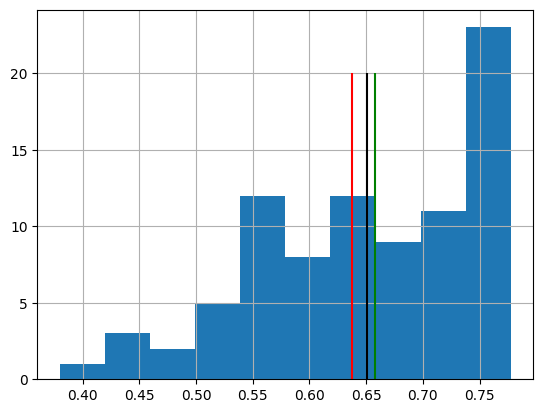

In [51]:
data['value'].hist()
plt.vlines(actual, 0, 20, color='red')
plt.vlines(data['value'].mean(), 0, 20, color='black')
plt.vlines(data['value'].median(), 0, 20, color='green')

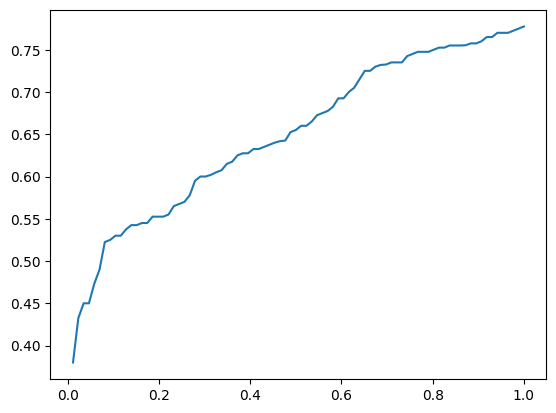

In [95]:
y = np.sort(data['value'].values)
x = np.cumsum(np.ones(len(y)) / len(y))
plt.plot(x, y)

In [96]:
threshold = 0.005

neighbors = [ticker for ticker, dist in dists.items() if dist < threshold]
neighbors

['AAPL', 'A', 'MCHP', 'TSCO', 'DOW', 'EXPD', 'POOL', 'CAG', 'CPB', 'PAYC']

In [63]:
len(neighbors)

10

In [68]:
actual = quarterly_actual['AAPL', 2020, 2]
actual_datetime = pd.to_datetime(f'{actual[1]} {actual[2]}', format='%Y-%m-%d %H:%M:%S')

sample_list = []
for ticker in neighbors:
    raw_data = quarterly_data[ticker, 2020, 2]
    filtered_data = raw_data[raw_data['ann_datetime'] < actual_datetime]
    print(ticker, filtered_data.shape, raw_data.shape)
    sample_list.append(filtered_data['value'].values)

AAPL (86, 2) (86, 2)
A (23, 2) (24, 2)
MCHP (55, 2) (58, 2)
TSCO (52, 2) (52, 2)
DOW (43, 2) (43, 2)
EXPD (18, 2) (18, 2)
POOL (14, 2) (14, 2)
CAG (17, 2) (29, 2)
CPB (31, 2) (41, 2)
PAYC (10, 2) (18, 2)


In [116]:
barycenter = wass_barycenter(sample_list)

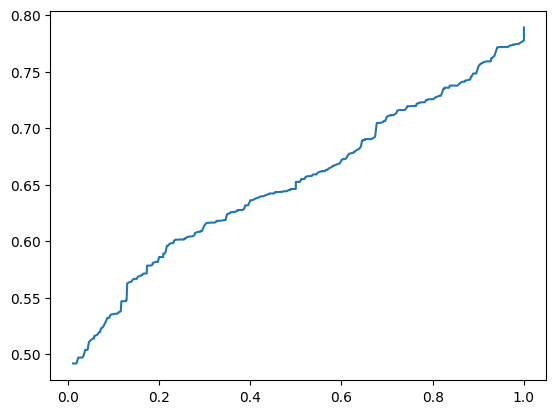

In [118]:
x,y = barycenter
plt.plot(x,y)

In [131]:
def expectation(barycenter):
    # This is just the integral from 0 to 1 of the quantile function
    x,y = barycenter
    x_diff = np.concatenate([np.array(x[0]).reshape(1), np.diff(x)])
    return np.sum(x_diff * y)

threshold = 0.05

neighbors = [ticker for ticker, dist in dists.items() if dist < threshold]
print(len(neighbors))
actual = quarterly_actual['AAPL', 2020, 2]
actual_datetime = pd.to_datetime(f'{actual[1]} {actual[2]}', format='%Y-%m-%d %H:%M:%S')

sample_list = []
for ticker in neighbors:
    raw_data = quarterly_data[ticker, 2020, 2]
    filtered_data = raw_data[raw_data['ann_datetime'] < actual_datetime]
    # print(ticker, filtered_data.shape, raw_data.shape)
    sample_list.append(filtered_data['value'].values)

barycenter = wass_barycenter(sample_list)
expectation(barycenter)

103


0.632738791618207

In [129]:
step_function(*barycenter, 0.5)

0.6438339805825241

Hyperparamter tuning: We can tune the hyperparameter threshold with for the first 50% of the columns and use them to predict the last 50% of the columns. The target this time will not be reconstructing the original distribution, but rather predicting the actual quarter EPS.

In [138]:
from hyperopt import hp, fmin, tpe
from numpy import half

def evaluate_eta_column(eta, ticker, year, quarter, row_dists, quarterly_actual, quarterly_data):
    """Return the squared error for estimating the actual EPS for the given eta and column.
    """
    neighbors = [t for t, dist in row_dists.items() if dist <= eta]
    if len(neighbors == 0):
        # this should never happen because a ticker should always be a neighbor with itself
        raise Exception(f"No neighbors found for {ticker,year,quarter}")
    actual = quarterly_actual[ticker, year, quarter]
    actual_datetime = pd.to_datetime(f'{actual[1]} {actual[2]}', format='%Y-%m-%d %H:%M:%S')
    actual_eps = actual[0]
    sample_list = []
    for t in neighbors:
        raw_data = quarterly_data[t, year, quarter]
        filtered_data = raw_data[raw_data['ann_datetime'] < actual_datetime]
        # We don't have to worry about empty dataframes since we have already filtered
        # to only only use non-empty dataframes when calculating distances
        sample_list.append(filtered_data['value'].values)
    barycenter = wass_barycenter(sample_list)
    barycenter_expectation = expectation(barycenter)
    return (barycenter_expectation - actual_eps) ** 2

def optimize_eta(ticker, quarterly_actual, quarterly_data):
    # We will use the first half of the columns to estimate eta
    rows, cols = get_rows_cols()
    
    halfway = len(cols)//2
    
    # Get distances for the first half of the columns
    row_dists = dict()
    for col in cols[:halfway]:
        dists = get_dist(ticker, col[0], col[1], quarterly_actual, quarterly_data)
        row_dists[col] = dists
    
    # Define the objective function
    def obj(eta):
        error = 0
        for col in cols[halfway:]:
            error += evaluate_eta_column(eta, ticker, col[0], col[1], row_dists[col], quarterly_actual, quarterly_data)
        return error
    
    # Optimize the objective function
    best_eta = fmin(fn=obj, verbose = True, space=hp.uniform('eta', 0.0001, 10.0), algo=tpe.suggest, max_evals=30)
    return best_eta['eta']

In [144]:
quarterly_data['SW', 2020, 2]

,value,ann_datetime
4,0.830,2024-07-31 00:13:00
5,0.790,2024-07-31 00:16:00
6,0.620,2024-07-31 00:21:00
7,0.790,2024-09-13 09:22:00
8,0.770,2024-10-07 18:06:00
9,0.720,2024-10-10 19:16:00
10,0.804,2024-10-11 03:15:00
11,0.750,2024-10-18 06:49:00
12,0.710,2024-10-28 02:11:00


In [139]:
eta = optimize_eta('AAPL', quarterly_actual, quarterly_data)

KeyError: ('SW', 2020, 3)